# Land Use Categorization for TMD23
This is intended to be a demo implementing the new definitions of land use categorizations for the Trip Generation step of the TDM23 (travel demand model in development). This notebook starts with categorization of Central Business Districts (CBDs).


Started March 30th, 2021 - Margaret Atkinson

#### Requirements:
This is running as a ipynb in Jupyter Notebooks in an Anaconda environment that contains the following:
- Python 3.7
- numpy
- pandas
- openmatrix
- matplotlib
- descartes
- ipympl
- geopandas
- nb_conda
- nb_conda_kernels
- folium
- branca
- jenkspy (INSTALL FIRST)

For more information on how this environment was set up, see: https://github.com/bkrepp-ctps/mde-prototype-python

#### Just a note about environments:

This script seems to require pyproj > 2.2. The environment base_py_37_branca seems to have this.

Hypothesis: In order for pyproj to deal with CRS (coordinate reference systems) in the geodataframes - we need to be using the most recent version of pyproj. See: https://geopandas.org/docs/user_guide/projections.html#upgrading-to-geopandas-0-7-with-pyproj-2-2-and-proj-6

This changes how we specify CRSs. Also note that going from pivot table back to geodataframe (even though the pivot table has geometry) we need to specify the CRS - which should be the same CRS that the data came out of.

Using a version of pyproj that uses the {'init': 'ESPG4326'} format is giving me inconsistent results - sometimes maintaining the CRS and sometimes not. This causes the buffers to be larger than desired and causes problems for spatial join.


#### Links about Decay Functions
- https://aceso.readthedocs.io/_/downloads/en/latest/pdf/
- https://geographicdata.science/book/notebooks/04_spatial_weights.html
- https://github.com/pysal/pysal


## Definitions:
Higher classes are exclusions for lower classes (e.g. if TAZ is both CBD and Dense Urban, it will only be CBD).
### CBD
CBD: A TAZ is marked as a CBD if it is within 0.5 miles of two heavy rail (subway) stops from two different lines.

Methodology Plan: Buffer each heavy rail stop and dissolve by line to get one buffer per heavy rail line. Count the number of heavy rail line buffers intersect with each TAZ. If number is >1, the TAZ is a CBD.

Data: (shapefiles)
- TAZ's (polygons)
- Heavy Rail Stops with Line field (points)

Notes:
- May also have an additional filter: 
    - The TAZ must be over 50% covered by the overlap of two heavy rail stop buffers of different lines (like red/orange)

### Dense Urban
#### Basic Definition:

(0.5 mile buffer for heavy rail stops) OR (0.5 mile buffer for CR stops AND Urban density of landuse) OR (0.5 mile buffer for 5 mins headway overlapping bus routes AND Urban density of model landuse)

- *headway is frequency - buses must run every 5 minutes in the AM model period*

#### GIS Definition:

A TAZ is defined as Dense Urban if the TAZ does not meet the criteria for a CBD and meets one of the follow criteria:
1. TAZ must intersect with a 0.5 mile buffer for heavy rail stops OR 
2. (a TAZ must intersect with 0.5 mile buffer for CR stops AND meet the landuse density threshold for Urban density) OR 
3. (a TAZ must intersect with overlapping sections of 0.5 mile buffers for bus routes with 5 mins headway for the AM period in the model AND the TAZ must meet the landuse density threshold for Urban density)

#### Density (calculated at the TAZ level):

Density = (Population + Employment)/Area in Sq Mi
- [1] Urban density range is 10,000 - 3,805,119 ;  
- [2] Suburban density range is 5,000 - 9,999 ;  
- [3] Rural density is 0 - 4,999 ; 
- Boston Core includes TAZs 1-155 (we don't need this usually urban density, will fall in Urban density)

#### Notes: 
- Excludes CBD
- No overlapping heavy rail stops
- bus routes must overlap - the overlapping sections are intersected with the TAZs.

#### Data:
- Heavy rail stops (points) = Blue, Orange, Red lines (including Mattapan which counts as Red)
- Commute Rail stops (points)
- TAZs with population and employment (polygons)
- Bus routes with AM headway (5 minutes) 
    - (lines) = Modes 1, 2, 3, use AM_Headway <= 5
    - only MBTA


### Fringe Urban
(1  mile buffer for heavy rail stops) OR (0.5 mile buffer for light rail stops) OR (0.5 mile buffer of 15 mins AM headway for buses AND Suburban density) OR (0.5 mile buffer for CR stops AND Suburban density of model  landuse)

***Green line and Silver line are light rail (multiple modes, use them all) 


#### GIS Definition:

A TAZ is defined as Fringe Urban if the TAZ does not meet the criteria for a CBD or Dense Urban and meets one of the follow criteria:
1. TAZ must intersect with a 1 mile buffer for heavy rail stops OR 
2. (TAZ must intersect with a 0.5 mile buffer for light rail stops) OR
3. (a TAZ must intersect with 0.5 mile buffers for bus routes with 15 mins headway for the AM period in the model AND the TAZ must meet the landuse density threshold for suburban density) OR
4. (a TAZ must intersect with 0.5 mile buffer for CR stops AND meet the landuse density threshold for suburban density)

#### Data:
- Heavy rail stops (points) = Blue, Orange, Red lines (including Mattapan which counts as Red)
- Commuter Rail stops (points)
- Light Rail stops (points) = Green and Silver lines.
- TAZs with population and employment (polygons)
- Bus routes with AM headway (5 minutes) 
    - (lines) = Modes 1, 2, 3, use AM_Headway <= 5
    - only MBTA

### Suburban
Basic Definition:
0.5 mile buffer for any transit line (exclude CR , private buses)

GIS Definition:
TAZs that are not CBD, Dense Urban, or Fringe Urban AND intersect with a 0.5 mile buffer for any transit line (excluding CR and private bus lines).

### Rural
Definition of exclusion:
All TAZs that are not CBD, Dense Urban, Fringe Urban, or Suburban.

In [1]:
#IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import copy

In [16]:
#Import Data
#import TAZ shapefile
#(https://geopandas.org/docs/user_guide/io.html)
#taz = "G:\Data_Resources\DataStore\Ben_Marg_Proto\candidate_CTPS_TAZ_STATE_2019.shp"
taz = "G:\Regional_Modeling\Projects\Landuse Type_Project\To Margrate\TAZ_LUType_CRS.shp"
    #load into a geodataframe
taz = gpd.read_file(taz)
    #filter to just be TAZ ID and geometry
taz = taz[['ID',"TOT_EMP", "TOT_POP",'geometry', 'AREA']]
    #rename ID to TAZ_ID
taz = taz.rename(columns={"ID":"TAZ_ID"})

#import all stops (must have line column)
stops = "G:\Regional_Modeling\Projects\Landuse Type_Project\To Margrate\Model_Stops_CRS.shp"
stops = gpd.read_file(stops)

#import all transit routes
routes = "G:\Regional_Modeling\Projects\Landuse Type_Project\To Margrate\Model_Routes_CRS.shp"
routes = gpd.read_file(routes)

#transform TAZ and stop layers' CRS to CTPS Standard - "EPSG:26986" (Massachusetts State Plane)
taz = taz.to_crs("EPSG:26986")
stops = stops.to_crs("EPSG:26986")
routes = routes.to_crs("EPSG:26986")

routes.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Filtering and Cleaning the Data
This section is about filtering and setting up data products for use in all future sections. This means that the analysis for each section doesn't involve setting up data and data that is shared is stored in a common place.

In [17]:
#FILTER THE STOPS

#HEAVY RAIL (CBD, DENSE URBAN)
#filter all stops to just heavy rail stops (and make a copy)
hr_stops = copy.deepcopy(stops.loc[stops['MODE'].isin([5,6,7,8])]) 
#mode 4 is Green, 5 is Red, Mattapan is 6 (Ashmont to Mattapan), Blue is 8, Orange is 7
    #Treat Mattapan as 5 (red)
    #https://stackoverflow.com/questions/34499584/use-of-loc-to-update-a-dataframe-python-pandas
#hr_stops['MODE'] = hr_stops['MODE'].replace(6,5) #don't use this line - gives SettingWithCopyWarning
hr_stops.loc[hr_stops['MODE'] == 6, 'MODE'] = 5 #this line does the same thing as above
#filter
hr_stops = hr_stops.loc[:,['ID', 'MODE', 'STOP_NAME', 'geometry']]
#check
hr_stops[hr_stops['MODE'].isin([6])] 

,ID,MODE,STOP_NAME,geometry


In [18]:
#COMMUTER RAIL (DENSE URBAN)
#filter all stops to just commuter rail stops (and make a copy)
cr_stops = copy.deepcopy(stops.loc[stops['MODE'].isin([9,32,33,34,35,36,37,38,39,40])]) 
#filter
cr_stops = cr_stops.loc[:,['ID', 'MODE', 'STOP_NAME', 'geometry']]
cr_stops.head()

,ID,MODE,STOP_NAME,geometry
20946,247157,32,NORTH STATION_ROCKPORT,POINT (236066.773 901844.302)
20947,247158,32,RIVER WORKS,POINT (243637.455 911189.761)
20948,247159,32,SALEM,POINT (249644.649 919538.922)
20949,247160,32,CHELSEA,POINT (238323.440 905121.969)
20950,247161,32,SWAMPSCOTT,POINT (247487.350 913848.626)


In [19]:
#BUS ROUTES (DENSE URBAN, FRINGE URBAN)
#0 MEAN NOT RUNNING 
bus_routes = copy.deepcopy(routes.loc[routes['MODE'].isin([1,2,3])]) 

#<=5 minute headway (DENSE URBAN)
bus5r = bus_routes.loc[(bus_routes['SCEN_00_AM'] <= 5) &(bus_routes['SCEN_00_AM'] > 0)]
#<=15 minute headway (FRINGE URBAN)
bus15r = bus_routes.loc[(bus_routes['SCEN_00_AM'] <= 15) &(bus_routes['SCEN_00_AM'] > 0)]
#check
bus5r['SCEN_00_AM'].value_counts()

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [20]:
#Calculate Density for TAZs
#Density = (Population + Employment)/Area in Sq Mi
    #TAZs units are in meters (CRS) so convert to miles
######TESTING#########
#taz = "G:\Regional_Modeling\Projects\Landuse Type_Project\To Margrate\TAZ_LUType_CRS.shp"
    #load into a geodataframe
#taz = gpd.read_file(taz)

    #filter to just be TAZ ID and geometry
#taz = taz[['ID',"TOT_EMP", "TOT_POP",'geometry', 'AREA', 'DENSITY']]
    #rename ID to TAZ_ID
#taz = taz.rename(columns={"id":"TAZ_ID"})
#taz['AreaPy'] = taz['geometry'].area *0.00000038610215855
#######END TESTING#####

taz['DensPy'] = (taz['TOT_POP']+taz['TOT_EMP'])/taz['AREA']

#Flag Urban, Suburban, Rural
taz['Den_Flag'] = np.where(taz['DensPy'] >= 10000, 1, 
                          np.where(taz['DensPy'] < 5000, 3, 2))
taz.loc[taz['Den_Flag']<3]

,TAZ_ID,TOT_EMP,TOT_POP,geometry,AREA,DensPy,Den_Flag
78,1891,2970.0,348.0,"POLYGON ((249498.429 878242.384, 249438.536 87...",0.641429,5172.825052,2
89,1834,4075.0,685.0,"POLYGON ((247949.885 882747.003, 247946.553 88...",0.769503,6185.810842,2
90,1832,292.0,3460.0,"POLYGON ((248009.987 883320.896, 247949.885 88...",0.681402,5506.294375,2
92,1902,1746.0,133.0,"POLYGON ((251156.619 879694.204, 251173.163 87...",0.285792,6574.711678,2
96,1858,1224.0,446.0,"POLYGON ((251263.535 888455.789, 251254.866 88...",0.319264,5230.780796,2
...,...,...,...,...,...,...,...
4478,1931,1851.0,222.0,"POLYGON ((268345.197 929108.016, 268359.054 92...",0.117916,17580.311408,1
4481,1936,1109.0,2645.0,"POLYGON ((273757.694 934760.066, 273746.269 93...",0.569050,6596.959845,2
4486,1928,402.0,1123.0,"POLYGON ((268130.277 929943.313, 268133.322 92...",0.078450,19439.133206,1
4487,1930,866.0,3148.0,"POLYGON ((269009.004 929886.603, 269000.039 92...",0.361573,11101.492645,1


## CBD

<AxesSubplot:>

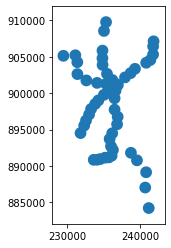

In [21]:
#BUFFER CELL

#convert the 0.5 mile buffer distance into meters (CRS is in meters)
buf5 = 0.5*1609.34

#make a copy of hr_stops to buffer
hr_buf = copy.deepcopy(hr_stops) #new used to just be hr_buf = hr_stops

#Buffer the heavy rail stops
#(https://geopandas.org/docs/user_guide/geometric_manipulations.html)
#(https://gis.stackexchange.com/questions/253224/geopandas-buffer-using-geodataframe-while-maintaining-the-dataframe)
    #keep attribute data by replacing the geometry column
hr_buf['geometry']= hr_buf.buffer(buf5)

#group by line and dissolve
#(https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html)
    #.reset_index() is because the by=field will turn the field into the index and have it not be a col
hr_buf_dis = hr_buf.dissolve(by='MODE').reset_index()

#only get what we need
hr_buf_dis = hr_buf_dis[['MODE', 'geometry']]
hr_buf_dis.plot()

In [22]:
#make sure everything is kosher
#hr_buf_dis.crs="EPSG:26986"
#hr_buf_dis = gpd.GeoDataFrame(hr_buf_dis)

#hr_buf_dis.plot()
#hr_buf_dis.crs="EPSG:26986"
hr_buf_dis.crs 

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### CBD: Intersect and Count Method TWO!

In [23]:
#INTERSECT TRY 2
#split into individual geodataframes to intersect
red = hr_buf_dis[hr_buf_dis['MODE'] == 5]
blue = hr_buf_dis[hr_buf_dis['MODE'] == 7]
orange = hr_buf_dis[hr_buf_dis['MODE'] == 8]

rb = gpd.overlay(red, blue, how='intersection')
ob = gpd.overlay(orange, blue, how='intersection')
ro = gpd.overlay(red, orange, how= 'intersection')

rbob = gpd.overlay(rb, ob, how='union')
rbobro = gpd.overlay(rbob, ro, how='union',keep_geom_type=False)
rbobro['MODE'] = 578
rbobro = rbobro.dissolve(by='MODE').reset_index()
rbobro = rbobro[['MODE', 'geometry']]
rbobro

taz_hr = gpd.overlay(taz, rbobro, how='intersection')
taz_hr
#taz_hr.plot()

,TAZ_ID,TOT_EMP,TOT_POP,AREA,DensPy,Den_Flag,MODE,geometry
0,26,911.0,1817.0,0.257656,10587.760425,1,578,"POLYGON ((235283.363 901007.534, 235330.727 90..."
1,25,439.0,2160.0,0.067535,38483.749167,1,578,"POLYGON ((235330.727 901008.772, 235283.363 90..."
2,28,924.0,2417.0,0.044105,75751.048634,1,578,"POLYGON ((235470.732 900723.784, 235449.860 90..."
3,628,842.0,334.0,0.091417,12864.128116,1,578,"POLYGON ((235020.407 901997.703, 235041.017 90..."
4,27,241.0,2720.0,0.024206,122325.043378,1,578,"POLYGON ((235755.326 901073.345, 235721.065 90..."
...,...,...,...,...,...,...,...,...
91,8,495.0,1393.0,0.018891,99941.771214,1,578,"POLYGON ((236848.944 901905.085, 236843.260 90..."
92,23,4117.0,10.0,0.014965,275776.812563,1,578,"POLYGON ((235365.425 901316.744, 235364.843 90..."
93,40,1600.0,37.0,0.008759,186893.480991,1,578,"POLYGON ((236019.222 900842.873, 236002.139 90..."
94,47,1745.0,35.0,0.008874,200585.981519,1,578,"POLYGON ((236351.189 900818.923, 236337.864 90..."


,TAZ_ID,TOT_EMP,TOT_POP,geometry,DensPy,Den_Flag,CBD_Flag,CBD_Perc
0,4398,1281.0,2489.0,"POLYGON ((246729.396 855385.947, 246722.786 85...",484.870934,3,0,0
1,2571,228.0,2060.0,"POLYGON ((247846.933 856739.946, 247846.686 85...",639.266855,3,0,0
2,2669,535.0,1523.0,"POLYGON ((249688.217 857104.522, 249688.216 85...",332.415073,3,0,0
3,4392,242.0,1441.0,"POLYGON ((251073.140 851003.532, 251079.000 85...",219.129925,3,0,0
4,2569,335.0,2075.0,"POLYGON ((248772.665 859041.357, 248774.263 85...",981.813634,3,0,0


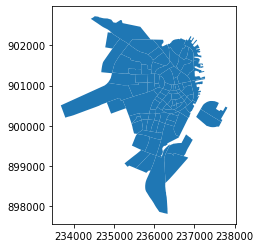

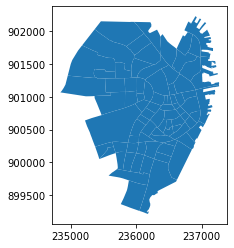

In [24]:
#COUNT TRY 2
#caculate area
#taz_hr.area
taz_hr['area_int'] = taz_hr.area
taz['taz_area'] = taz.area
#join intersecting areas back to main TAZ
taz_int = taz.merge(taz_hr, how='left', on='TAZ_ID')
#get percent of taz that is intersecting
taz_int['perc_hr'] = taz_int['area_int']/taz_int['taz_area']

#flag TAZ's
taz_int['CBD_Flag'] = np.where(taz_int.area_int >0, 1, 0)
taz_int['CBD_Perc'] = np.where(taz_int.perc_hr >0.4, 1, 0)
#turn back into geodataframe - geometry is TAZ (not intersections of TAZ and buffers)
taz_int = taz_int.rename(columns={'geometry_x':'geometry', 'TOT_EMP_x' : 'TOT_EMP', 'TOT_POP_x': 'TOT_POP',
                                  'DensPy_x':'DensPy', 'Den_Flag_x': 'Den_Flag'})
taz_int = gpd.GeoDataFrame(taz_int)
taz_int = taz_int[['TAZ_ID', 'TOT_EMP', 'TOT_POP', 'geometry', 'DensPy', 'Den_Flag', 'CBD_Flag', 'CBD_Perc']]

#make testing outputs
CBD_TAZ2 = taz_int[taz_int['CBD_Flag'] == 1]
CBD_TAZperc = taz_int[taz_int['CBD_Perc'] == 1]

CBD_TAZ2 = CBD_TAZ2[['TAZ_ID', 'geometry', 'CBD_Flag']]
CBD_TAZperc = CBD_TAZperc[['TAZ_ID', 'geometry', 'CBD_Perc']]
CBD_TAZ2.plot()
CBD_TAZperc.plot()
taz_int.head()

### CBD: Intersect and Count Method One!

In [51]:
#INTERSECT AND COUNT CELL

#do a spatial join between TAZ and buffers
#(https://geopandas.org/docs/user_guide/mergingdata.html)
hr_sj = gpd.sjoin(taz,hr_buf_dis,how ="left", op="intersects")

hr_sj.crs


#make pivot table counting for each TAZ ID how many Line_IDs
    #note each line should only have one polygon so a taz should not be able to have multiple intersections with the same LineID
    ##keep geometry, count mode
#(https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html)
hr_pv = pd.pivot_table(hr_sj, index = "TAZ_ID", aggfunc={'MODE':'count', 'geometry': 'first'}).reset_index()
hr_pv = gpd.GeoDataFrame(hr_pv)
hr_pv.crs="EPSG:26986"

hr_pv

,TAZ_ID,MODE,geometry
0,1,3,"POLYGON ((235848.827 901768.399, 235835.856 90..."
1,2,3,"POLYGON ((235983.175 901640.457, 235978.313 90..."
2,3,3,"POLYGON ((235967.030 901591.944, 235967.790 90..."
3,4,2,"POLYGON ((236117.919 901965.053, 236042.500 90..."
4,5,2,"POLYGON ((236782.571 902122.456, 236733.885 90..."
...,...,...,...
5834,209096,0,"POLYGON ((175597.791 827256.284, 174355.560 82..."
5835,209097,0,"POLYGON ((174954.719 811883.330, 174090.112 81..."
5836,209098,0,"POLYGON ((175227.519 810875.763, 174088.044 81..."
5837,209099,0,"POLYGON ((174906.641 797986.038, 173096.928 79..."


In [52]:
#rename Line_ID count field
hr_pv = hr_pv.rename(columns={"MODE":"MODE_COUNT"})

#make CBD flag field (conditional - 1 where CBD, 0 where not)
#(https://cmdlinetips.com/2019/05/how-to-create-a-column-using-condition-on-another-column-in-pandas/)
hr_pv['CBD_Flag'] = np.where(hr_pv.MODE_COUNT >1, 1, 0)

#filter to just have CBD TAZs
#(https://www.geeksforgeeks.org/ways-to-filter-pandas-dataframe-by-column-values/)
CBD_TAZ = hr_pv[hr_pv['CBD_Flag'] == 1]

CBD_TAZ

,TAZ_ID,MODE_COUNT,geometry,CBD_Flag
0,1,3,"POLYGON ((235848.827 901768.399, 235835.856 90...",1
1,2,3,"POLYGON ((235983.175 901640.457, 235978.313 90...",1
2,3,3,"POLYGON ((235967.030 901591.944, 235967.790 90...",1
3,4,2,"POLYGON ((236117.919 901965.053, 236042.500 90...",1
4,5,2,"POLYGON ((236782.571 902122.456, 236733.885 90...",1
...,...,...,...,...
145,146,2,"POLYGON ((236789.530 899785.961, 236830.814 89...",1
146,147,2,"POLYGON ((236727.250 899247.574, 236821.090 89...",1
624,625,2,"POLYGON ((235365.474 902027.539, 235274.972 90...",1
625,626,2,"POLYGON ((235150.211 902165.195, 235100.600 90...",1


In [32]:
#show a map of the result symbolized on CBD flag field.
%matplotlib
#hr_pv = gpd.GeoDataFrame(hr_pv)
hr_pv.plot(column = 'MODE_COUNT',figsize=(10.0,8.0), legend=True)

Using matplotlib backend: Qt5Agg


<AxesSubplot:>

## Dense Urban 

<AxesSubplot:>

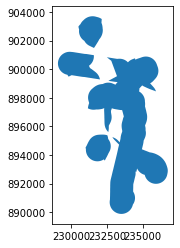

In [69]:
#Buffering everything for Dense Urban
#convert the 0.5 mile buffer distance into meters (CRS is in meters)
buf5 = 0.5*1609.34

#make copies of everything to buffer
cr_buf = copy.deepcopy(cr_stops) #new used to just be hr_buf = hr_stops
hr_buf = copy.deepcopy(hr_stops) #replaces previous hr_buf, but idential to previous hr_buf
bus5r_buf = copy.deepcopy(bus5r)

#Buffer everything!!!
cr_buf['geometry']= cr_buf.buffer(buf5)
hr_buf['geometry']= hr_buf.buffer(buf5)
bus5r_buf['geometry']= bus5r_buf.buffer(buf5) #this is wrong!!! Only need overlapping sections!

#dissolve hr and cr
hr_buf_dis_du = hr_buf.dissolve().reset_index()
cr_buf_dis = cr_buf.dissolve().reset_index()

#get just overlapping sections of bus routes
    #create overlapping sections
bus_int = {}
for i, row in bus5r_buf.iterrows():
    row_gdf = bus5r_buf.query('ROUTE_ID == ' + str(row['ROUTE_ID']))
    row_gdf.to_crs("EPSG:26986")
    
    for i2, row2 in bus5r_buf.iterrows():
        if row['ROUTE_NAME'][0:2] != row2['ROUTE_NAME'][0:2]:
            name = str(row['ROUTE_NAME'][0:2]) + '-' + str(row2['ROUTE_NAME'][0:2])
            rev_name = str(row2['ROUTE_NAME'][0:2]) + '-' + str(row['ROUTE_NAME'][0:2])

            if name not in bus_int.keys() and rev_name not in bus_int.keys():
                row2_gdf = bus5r_buf.query('ROUTE_ID == ' + str(row2['ROUTE_ID']))
                row2_gdf.to_crs("EPSG:26986")
                bus_int[name] = gpd.overlay(row_gdf, row2_gdf, how = 'intersection')

    #create one geodataframe of intersectioned places 
count = 0 
delkey = []
for key in bus_int.keys():
    if bus_int[key].empty:
        delkey.append(key)
    else:
        if count == 0:
            whole = bus_int[key]
            count += 1
        else:
            whole = whole.append(bus_int[key])
    #dissolve geodataframe of intersections into one shape        
bus5r_buf_int_dis = whole.dissolve()
bus5r_buf_int_dis.plot()

In [78]:
hr_buf_dis_du

,index,geometry,ID,MODE,STOP_NAME
0,0,"MULTIPOLYGON (((241751.607 883664.083, 241693....",211628,7,OAK GROVE


In [ ]:
#Calculate Flag Field
taz_du = copy.deepcopy(taz_int) #join basic taz with taz_int
'''taz_du['DU_Flag'] = np.where((taz_du['CBD_Flag'] != 1) & (taz_du.intersects(hr_buf_dis_du)), 1,
        np.where((taz_du['CBD_Flag'] != 1) & (taz_du.intersects(cr_buf_dis)) & (taz_du['Den_Flag'] == 1), 1,
                np.where((taz_du['CBD_Flag'] != 1) & (taz_du.intersects(bus5r_buf_int_dis)) & (taz_du['Den_Flag'] == 1), 1,0)))'''
cr_list = []
hr_list = []
bus5_list = []
count = 0

for index, row in taz_du.iterrows():
    if gpd.overlay(hr_buf_dis_du, taz_du.query("TAZ_ID == "+str(row['TAZ_ID'])), how = 'intersection').empty == False:
        hr_list.append(row['TAZ_ID'])
    if gpd.overlay(cr_buf_dis, taz_du.query("TAZ_ID == "+str(row['TAZ_ID'])), how = 'intersection').empty == False:
        cr_list.append(row['TAZ_ID'])
    if gpd.overlay(bus5r_buf_int_dis, taz_du.query("TAZ_ID == "+str(row['TAZ_ID'])), how = 'intersection').empty == False:
        bus5_list.append(row['TAZ_ID'])
    #if row.geometry.intersects(cr_buf_dis):
        #cr_list.append(row['TAZ_ID'])
    #if row.geometry.intersects(bus5r_buf_int_dis):
        #bus5_list.append(row['TAZ_ID'])
    count +=1
    #if count == 1:
        #print(row.geometry)
taz_du['DU_Flag'] = np.where(((taz_du['CBD_Flag'] != 1) & (taz_du['TAZ_ID'] in hr_list)) | ((taz_du['CBD_Flag'] != 1) & (taz_du['TAZ_ID'] in cr_list) & (taz_du['Den_Flag'] == 1)) | ((taz_du['CBD_Flag'] != 1) & (taz_du['TAZ_ID'] in bus5_list) & (taz_du['Den_Flag'] == 1)) , 1,0)
taz_du.query('DU_Flag == 1')


## Exports for Testing

In [24]:
#output as shapefile
# Output path
outfp = r"C:\Users\matkinson\Downloads\TAZ_CBD5.shp"

CBD_TAZ = gpd.GeoDataFrame(CBD_TAZ)
# Save to disk
CBD_TAZ.to_file(outfp)

In [25]:
outfp = r"C:\Users\matkinson\Downloads\test5.shp"

hr_sj = gpd.GeoDataFrame(hr_sj)
# Save to disk
hr_sj.to_file(outfp)

C:\Users\matkinson\Anaconda3\envs\base_py_37_branca\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """


In [26]:
outfp = r"C:\Users\matkinson\Downloads\buf5.shp"

#hr_buf_dis = gpd.GeoDataFrame(hr_buf_dis)
# Save to disk
hr_buf_dis.to_file(outfp)

In [130]:
outfp = r"C:\Users\matkinson\Downloads\rbobro.shp"

#hr_buf_dis = gpd.GeoDataFrame(hr_buf_dis)
# Save to disk
rbobro.to_file(outfp)

outfp = r"C:\Users\matkinson\Downloads\taz_hr.shp"

#hr_buf_dis = gpd.GeoDataFrame(hr_buf_dis)
# Save to disk
taz_hr.to_file(outfp)

In [131]:
outfp = r"C:\Users\matkinson\Downloads\ro.shp"

#hr_buf_dis = gpd.GeoDataFrame(hr_buf_dis)
# Save to disk
ro.to_file(outfp)

In [141]:
outfp = r"C:\Users\matkinson\Downloads\CBD_TAZperc5.shp"

CBD_TAZperc.to_file(outfp)

outfp = r"C:\Users\matkinson\Downloads\CBD_TAZ2.shp"
CBD_TAZ2.to_file(outfp)

In [7]:
outfp = r"C:\Users\matkinson\Downloads\CBD_TAZperc4.shp"

CBD_TAZperc.to_file(outfp)

In [70]:
outfp = r"C:\Users\matkinson\Downloads\bus5r_buf.shp"

bus5r_buf.to_file(outfp)